In [1]:
import importlib
import library.nbtool as nbtool; importlib.reload(nbtool)
import parser.lycee as lycee;    importlib.reload(lycee)
from parser.lycee import *

sorted collection imported


# Read the dataset and construct the multi stream graph

In [2]:
Lycee = MultiStream(interval, LYCEE, LayerList([]), LinkList([]))
liste, liste2 = readNodes(Lycee, ["face_to_face", "facebook", "friendship"])
ti, ni = readLinks(Lycee, liste)
readLinks2(Lycee, liste, liste2)   # read facebook links
readLinks3(Lycee, liste, liste2)   # read friendship links

readlink2...
readlink3...
link3 done


## Various types of layer definitions

In [3]:
_math_physics = layerWithCommonPoint(LYCEE, "annee", "MP")
MathPhysics = Lycee.extractLayers(_math_physics)

_girls, _boys = [layerWithCommonPoint(LYCEE, 'sexe', sexe) for sexe in ['F', 'M']]
Girls   = Lycee.extractLayers(_girls)
Boys    = Lycee.extractLayers(_boys)
UniSex  = Lycee.interLayers(_girls, _boys)

_f2f = layerWithCommonPoint(LYCEE, "typeOfRel", "face_to_face")  # face to face layer
F2F     = Lycee.extractLayers(_f2f)

## Cut the Multi-layer stream graph (MLSG) in a window of time

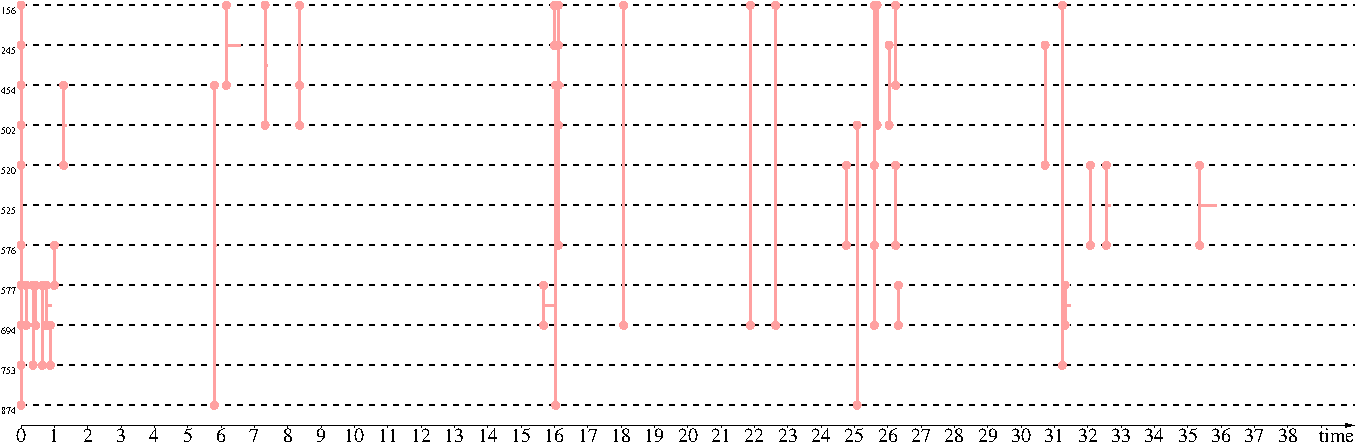

/Users/wakita/Dropbox/projects/mxvis/mx-streams/src/outputs/mp_girls.png

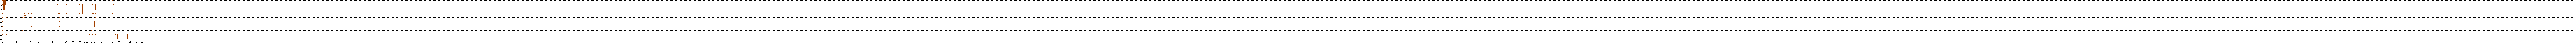

/Users/wakita/Dropbox/projects/mxvis/mx-streams/src/outputs/mp_girls_ordonne.png

In [4]:
# Face to face relationship among girls taking Math & Physics during the period [0, 40]
mp_girls = Lycee.cut(Interval(0, 40)).extractLayers(_math_physics).extractLayers(_girls).extractLayers(_f2f)

nbtool.drawMS(mp_girls, name='mp_girls', show=True)
nbtool.drawMS(mp_girls, name='mp_girls_ordonne', show=True, ordonne=True)

## Bug

`mp_firls_ordonne.fig` is broken.  If you expand by x50 the png file and you will see what is happening.  Somehow when `ordonne=True` is specified the drawMS seem to resets the interval.  This is not the case with Pimprenelle's original implementation.  I think this is due to inappropriate implicit reference of a global variable in my implementation.

# A summary of the Stream Graph API

## `elemMSGraph`

- Layers: layerStruct, layers, numberOfNodeLayers
- Nodes: nodes, numberOfNodes
- Links: giveLinks
- Paths: enumShortestPath, foremostPath
- Structural operations
    - interval
    - giveLayers, giveListForForemost, giveListForLastDept
    - cut, extractLayers, extractML
    - directed
    - interLayers
- Computate indices
    - calculMatriceProbaTransition
    - calculProba
    - computeCovMatrix, computeLengthEm, comupteIntricationMatrixBurtMS
    - computeDensity, computeDensityBiparti, elemLayerDensitiesMat, elemLayerDensitiesMatDiag0
- Unknown
    - avionsSuivants, em, findWindows, lastDeptPath, multit, ordreAretes

## `elemMSGraph.LinkList`

`mp_girls.giveLinks() : visuMultiStream.MultiStream = `

- addLink
- countLinks: `#giveListofLinks()`?
- giveIndex: gives the index number for a node
- giveListFor{Enum, Foremost, LastDept}
- giveListofLinks
- length
- listOfLinks

In [5]:
edges = mp_girls.giveLinks()
link = edges.listOfLinks[0]
#print(dir(link)); print()
#link.printLink(); print()

intervals = link.giveIntervals()  # link.intervals (interval collection object), link.giveIntervals2 (???)
print(f'{link.node1.node} -> {link.node2.node}: #{len(intervals)}, {link.giveLength()}')

n1 = link.node1
# n1.node: str

# BUG with the stream graph API?  I don't understand the following
# I expect numberOfNodes == len(nodes).
# How can I obtain the node set?
(mp_girls.numberOfNodes(), mp_girls.nodes)

# dir(mp_girls)

156 -> 245: #2, 0.03999999999999915


(11.0, [])

# Conversion to NetworkX

For ease of manipulation, the stream graph layer is converted to a NetworkX undirected graph structure.  Firstly, the layer is decomposed into connected components.  It turned out that the layer is connected (one connected component).

In [6]:
import networkx as nx
import networkx.algorithms.components

G_mp_girls = nx.Graph()

for link in mp_girls.giveLinks().listOfLinks:
    n1, n2 = link.node1.node, link.node2.node
    G_mp_girls.add_nodes_from([n1, n2])
    G_mp_girls.add_edge(n1, n2)
    G_mp_girls.edges[n1, n2]['connections'] = len(link.giveIntervals())
    G_mp_girls.edges[n1, n2]['intervals'] = [(interval.t1, interval.t2) for interval in link.giveIntervals()]

connected_components = sorted(networkx.algorithms.components.connected_components(G_mp_girls),
                              key=len, reverse=True)

# Optimization

## Requirement: `z3`

`Z3` is a theorem prover from Microsoft Research implemented by C++ and offers interface to several programming languages including Python.

You need both the (C++ based) z3 constraint resolver and a Python interace to it.  On Mac, execute:

```
brew install z3
pip install z3-solver
```

In [7]:
# Constraint system: Solution takes less than a minute on iMac (Retina 5K, Late 2014 model - 4GHz Core i7, 16GB)

import z3

def Abs(x): return z3.If(x >= 0, x, -x)

solver = z3.Solver()
V = G_mp_girls.nodes
E = G_mp_girls.edges

# `Assignment` uniquely give vertical positions ([0, 1, ..., N-1]) to the nodes.
Assignment = [z3.Int('v' + n) for n in V]
assignment = dict(zip(V, Assignment))
for position in Assignment:
    solver.add(position >= 0)
    solver.add(position < len(V))
solver.add(z3.Distinct(Assignment))

# Objective function `Distance`: A weighted sum of the edge distances
Distance = z3.Sum([Abs(assignment[n1] - assignment[n2]) for n1, n2 in E])

# Optimization

history = []
max_distance = 1 << 31

while True:
    solver.add(Distance < max_distance)
    result = solver.check()
    if result != z3.sat: break
    current_best = solver.model()
    max_distance = current_best.evaluate(Distance)
    history.append(max_distance.as_long())

Solution = [(v, current_best[v].as_long()) for v in Assignment]
print(f'Solution: {Solution}')
print(f'Distance: {max_distance.as_long()}')
print(f'Optimum: {result == z3.unsat}')
print(f'History: {history}')

Solution: [(v156, 4), (v245, 5), (v454, 7), (v502, 8), (v694, 2), (v753, 1), (v520, 6), (v576, 3), (v874, 9), (v577, 0)]
Distance: 36
Optimum: True
History: [56, 53, 50, 49, 48, 45, 44, 43, 40, 38, 36]


## Preparation of edge information

Transforming link information: $(u, v, [(t_1, T_1), (t_2, T_2), ...])$ to

edge information: $(u, v, t, T)$.


In [8]:
# Link information

position = dict(zip(V, Solution))
edges = []
for i in E:
    v1, v2 = [position[v] for v in i]
    intervals = E[i]['intervals']
    edges += [(v1[1], v2[1], t1, t2) for (t1, t2) in intervals]

y1, y2, x1, x2 = [[e[i] for e in edges] for i in range(4)]

links = [([x1, x1], [y1, y2]) for y1, y2, x1, x2 in zip(y1, y2, x1, x2)]
x, y = [x for x, _ in links], [y for _, y in links]

# Visualization using Bokeh

## Requirement: Bokeh

```pip install bokeh```

In [9]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import *

In [11]:
output_notebook()

p = figure(plot_width=800, plot_height=250)
p.circle(x1, y1, size=5)
p.circle(x1, y2, size=5)
p.multi_line(x, y, width=2)
show(p)

Loading BokehJS ...

In [6]:
import sys
sys.maxsize

len(dict(a=1, b=2, c=3))
d1, d2 = dict(a=1, b=2), dict(c=3, d=4)
d3 = dict(d1, **d2)
d3

{'a': 1, 'b': 2, 'c': 3, 'd': 4}